In [28]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
from datasets import load_dataset

/mnt/disk1/anaconda3/envs/hieupcvp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
# from keras.preprocessing.text import text_to_word_sequence
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!pip install Keras-Preprocessing


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
import tensorflow as tf
from keras_preprocessing.text import text_to_word_sequence

2025-03-29 04:11:24.200067: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 04:11:24.214388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-29 04:11:24.232081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-29 04:11:24.237536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 04:11:24.253012: I tensorflow/core/platform/cpu_feature_guar

In [6]:
!pip install Preprocessor

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
import sys 
sys.path.insert(0 , '/mnt/disk1/hieupcvp/RNN/SentimenalAnalysis/week1/preprocessing')
import preprocessor


# Preparing dataset 

In [30]:
def get_data(train_file):
    train_dataset = pd.read_csv(f"{train_file}")
    test_dataset = pd.read_csv(r"/mnt/disk1/hieupcvp/RNN/SentimenalAnalysis/data/val.csv")
    X_train, y_train , X_test, y_test = train_dataset['text'] , train_dataset['label'] , test_dataset['text'] , test_dataset['label']
    return X_train , y_train , X_test, y_test

In [29]:
import xgboost as xg 

In [12]:
import string

In [31]:
# Function to clean and tokenize
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens
    
    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()                            # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)               # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)                    # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)                  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)         # Replace dash between words
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    tokens = tokenizer(text)                                            # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]                  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]                 # Remove digits
    tokens = [t for t in tokens if len(t) > 1]                          # Remove short tokens
    return tokens

In [32]:
def preprocess(X_train , X_test):

    stop_words = set(stopwords.words("english"))

    X_train = X_train.map(lambda x:clean_text(x, word_tokenize, stop_words))
    X_test= X_test.map(lambda x:clean_text(x, word_tokenize, stop_words))
    return X_train , X_test

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

def func(doc):  # n_jobs in GridSearch does not support lambda function
    return doc

def tokenize_tfidf(X_train , X_test , y_train , y_test):
    tfidf = TfidfVectorizer(
        analyzer='word',
        tokenizer=func,
        preprocessor=func) 

    tfidf.fit(X_train)
    X_train_tf = tfidf.transform(X_train)
    # dense_Xtrain = X_train_tf.toarray()
    X_test_tf = tfidf.transform(X_test)
    # dense_Xtest = X_train_tf.toarray()
    
    return X_train_tf , X_test_tf 
def to_dmatrix(X_train_tf , X_test_tf , y_train , y_test):
    
    train_dmatrix = xg.DMatrix(data = X_train_tf , label = y_train , missing = np.nan)
    test_dmatrix = xg.DMatrix(data = X_test_tf , label = y_test, missing = np.nan)

    return train_dmatrix , test_dmatrix


# XGBoost 

In [17]:
# from xgboost import XGBRegressor, XGBClassifier
# clf = XGBClassifier()
# clf.fit(X_train_tf, y_train)

In [18]:
from sklearn.model_selection import KFold

In [20]:
import xgboost as xg
import numpy as np

In [66]:
def train_xgboost(params , train_dmatrix , test_dmatrix):
        

    evals_result = {}

    model = xg.train(
        params, 
        train_dmatrix, 
        num_boost_round=5000, 
        evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
        evals_result=evals_result,  
        verbose_eval=True,
        early_stopping_rounds = 500
    )
    return model



In [67]:
def load_best_model(model , params , train_dmatrix, test_dmatrix, ):
    evals_result = {}
    best_iteration = model.best_iteration

    model = xg.train(
        params, 
        train_dmatrix, 
        num_boost_round=best_iteration+1, 
        evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
        evals_result=evals_result,  
        verbose_eval=True
    )
    return model, evals_result

In [68]:
def plotting(evals_result):
    
    # Extract RMSE values
    train_rmse = evals_result['train']['logloss']
    test_rmse = evals_result['test']['logloss']

    # Plot both Training and Test RMSE
    plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE", linestyle="--")
    plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
    plt.xlabel("Boosting Round")
    plt.ylabel("RMSE")
    # plt.ylim(0, 0.2)
    plt.title("XGBoost Training & Test RMSE Over Boosting Rounds")
    plt.legend()
    plt.show()



In [69]:
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [70]:
def make_prediction(model, test_dmatrix, y_test):
    pred = model.predict(test_dmatrix)  # Probabilities for binary/multi-class
    y_true = y_test

    # Convert to class labels
    if pred.ndim > 1:  # Multi-class
        y_pred = pred.argmax(axis=1)
    else:  # Binary
        y_pred = (pred > 0.5).astype(int)

    # Check for label mismatch (critical for multi-class)
    assert np.array_equal(np.unique(y_pred), np.unique(y_true)), \
           "Predicted/true labels differ!"

    # Choose metric averaging
    is_binary = len(np.unique(y_true)) == 2
    average = 'binary' if is_binary else 'weighted'

    # Compute metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average=average),
        'recall': recall_score(y_true, y_pred, average=average),
        'f1_score': f1_score(y_true, y_pred, average=average),
    }

    # Debug output
    print(f"Sample predictions: {pred[:5]}")
    print(f"Sample classes: {y_pred[:5]}")
    for name, value in metrics.items():
        print(f"{name}: {value:.5f}")

    return metrics

In [71]:
def run_xgboost_pipeline(train_file , xgb_params):
    X_train , y_train , X_test, y_test = get_data(train_file)
    X_train , X_test = preprocess(X_train ,X_test)
    X_train, X_test = tokenize_tfidf(X_train , X_test , y_train , y_test)
    train_dmatrix , test_dmatrix = to_dmatrix(X_train , X_test , y_train , y_test)
    first_model = train_xgboost(xgb_params , train_dmatrix , test_dmatrix)
    model ,evals_result = load_best_model(first_model , xgb_params , train_dmatrix , test_dmatrix)
    plotting(evals_result)
    xgb_result = make_prediction(model , test_dmatrix , y_test)
    return model , xgb_result

/mnt/disk1/anaconda3/envs/hieupcvp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[0]	train-logloss:0.68453	test-logloss:0.69470
[1]	train-logloss:0.68241	test-logloss:0.69114
[2]	train-logloss:0.68062	test-logloss:0.68802
[3]	train-logloss:0.67933	test-logloss:0.68546
[4]	train-logloss:0.67789	test-logloss:0.68342
[5]	train-logloss:0.67670	test-logloss:0.68123
[6]	train-logloss:0.67567	test-logloss:0.67978
[7]	train-logloss:0.67469	test-logloss:0.67837
[8]	train-logloss:0.67384	test-logloss:0.67664
[9]	train-logloss:0.67295	test-logloss:0.67484
[10]	train-logloss:0.67214	test-logloss:0.67368
[11]	train-logloss:0.67131	test-logloss:0.67220
[12]	train-logloss:0.67059	test-logloss:0.67082
[13]	train-logloss:0.66987	test-logloss:0.66979
[14]	train-logloss:0.66917	test-logloss:0.66881
[15]	train-logloss:0.66848	test-logloss:0.66761
[16]	train-logloss:0.66780	test-logloss:0.66679
[17]	train-logloss:0.66710	test-logloss:0.66605
[18]	train-logloss:0.66640	test-logloss:0.66436
[19]	train-logloss:0.66570	test-logloss:0.66378
[20]	train-logloss:0.66513	test-logloss:0.66385
[2

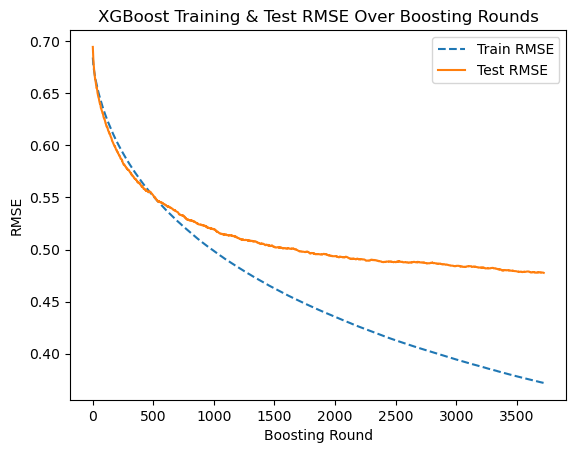

Sample predictions: [0.9466087  0.23089758 0.93294024 0.8064525  0.24541989]
Sample classes: [1 0 1 1 0]
accuracy: 0.78096
precision: 0.75149
recall: 0.85135
f1_score: 0.79831


In [115]:
train_file = "/mnt/disk1/hieupcvp/RNN/SentimenalAnalysis/data/train_orig_eda_embedding_wordnet.csv"
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
xgb_model , xgb_result = run_xgboost_pipeline(train_file=train_file , xgb_params= xgb_params)


# Random forest classification 

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [116]:

def rf_make_prediction(model, X_test, y_test):
    """Enhanced evaluation with class distribution check"""
    y_pred = model.predict(X_test)
    
    # Check for class imbalance
    unique, counts = np.unique(y_test, return_counts=True)
    print(f"\nClass distribution (test): {dict(zip(unique, counts))}")
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'oob_score': getattr(model, 'oob_score_', None)
    }
    print("\n=== Evaluation Metrics ===")
    for k, v in metrics.items():
        if v is not None:
            print(f"{k:>10}: {v:.5f}")
    
    return metrics

In [117]:

def run_rf_pipeline(train_file, rf_params={}):
    """
    Run Random Forest pipeline with training progress and evaluation.
    
    Args:
        train_file (str): Path to training data
        rf_params (dict): Custom Random Forest parameters (overrides defaults)
        
    Returns:
        model: Trained RandomForestClassifier
        results: Dictionary of evaluation metrics
    """
    # 1. Load and preprocess data
    X_train, y_train, X_test, y_test = get_data(train_file)
    X_train, X_test = preprocess(X_train, X_test)
    X_train, X_test = tokenize_tfidf(X_train, X_test, y_train, y_test)
    
    # 2. Set up model with default + custom params
    # default_params = {
    #     'n_estimators': 300,
    #     'max_depth': 4,
    #     'max_samples': 0.8,
    #     'max_features': 0.8,
    #     'bootstrap': True,
    #     'criterion': 'gini',
    #     'random_state': 42,
    #     'verbose': 1,
    #     'n_jobs': -1  # Enable parallel processing
    # }
    # final_params = {**default_params, **rf_params}  # Merge params
    
    # print("\n=== Training Random Forest ===")
    # print(f"Using parameters: {final_params}")
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # 3. Train with progress feedback
    try:
        rf_model.fit(X_train, y_train)
    except Exception as e:
        print(f"\nTraining failed: {str(e)}")
        raise
    
    # 4. Evaluate
    rf_result = make_prediction(rf_model, X_test, y_test)
    
    return rf_model, rf_result

In [118]:
train_file = "/mnt/disk1/hieupcvp/RNN/SentimenalAnalysis/data/train_orig_eda_embedding_wordnet.csv"

rf_model , rf_result = run_rf_pipeline(train_file)



/mnt/disk1/anaconda3/envs/hieupcvp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Sample predictions: [1 0 1 1 0]
Sample classes: [1 0 1 1 0]
accuracy: 0.78670
precision: 0.79452
recall: 0.78378
f1_score: 0.78912


# Decision Tree 

In [88]:
from sklearn import tree 

In [ ]:

def dt_make_prediction(model, X_test, y_test):
    """Evaluation for Decision Tree"""
    y_pred = model.predict(X_test)
    
    # Check class distribution
    unique, counts = np.unique(y_test, return_counts=True)
    print(f"\nClass distribution (test): {dict(zip(unique, counts))}")
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'depth': model.get_depth(),
        'leaves': model.get_n_leaves()
    }
    
    print("\n=== Evaluation Metrics ===")
    for k, v in metrics.items():
        print(f"{k:>10}: {v:.5f}" if isinstance(v, float) else f"{k:>10}: {v}")
    
    return metrics

In [110]:
def run_dt_pipeline(train_file , dt_params = {}):
    X_train, y_train, X_test, y_test = get_data(train_file)
    X_train, X_test = preprocess(X_train, X_test)
    X_train, X_test = tokenize_tfidf(X_train, X_test, y_train, y_test)
    
    # 2. Set up model with default + custom params
    default_params = {
        'criterion': 'gini',
        'splitter': 'best',
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': None,
        'random_state': 42,  # Essential for reproducibility
        'class_weight': None,
        'ccp_alpha': 0.0
    }
    final_params = {**default_params, **dt_params}  # Merge params
    
    print("\n=== Training Decision Tree ===")
    print(f"Using parameters: {final_params}")
    dt_model = tree.DecisionTreeClassifier(**final_params)
    dt_model.fit(X_train , y_train)
    
    
    dt_result = make_prediction(dt_model , X_test, y_test)
    return dt_model , dt_result 
    
    
    
    

In [114]:
train_file = "/mnt/disk1/hieupcvp/RNN/SentimenalAnalysis/data/train_orig.csv"
dt_model , dt_result = run_dt_pipeline(train_file)

/mnt/disk1/anaconda3/envs/hieupcvp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



=== Training Decision Tree ===
Using parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42, 'class_weight': None, 'ccp_alpha': 0.0}
Sample predictions: [1 0 1 0 0]
Sample classes: [1 0 1 0 0]
accuracy: 0.72592
precision: 0.73138
recall: 0.72973
f1_score: 0.73055
